# 10. Convolutional Neural Networks

Please work on Google Colab. (No.)

In [1]:
import os
import sklearn
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display

In [2]:
from tqdm import tqdm
from tqdm import trange

In [8]:
import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.optimizers import Adam
from keras.models import Sequential

from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [9]:
print(tf.__version__)

2.2.0


In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [11]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6983810985758047686,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13304516376056668369
 physical_device_desc: "device: XLA_CPU device"]

In [8]:
# gpu '1' is not working on tesla!!!
used_gpu = '0'

# training method
separate = True

# Train split
train_split = 0.35

In [5]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [6]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

### 1. Load the MNIST dataset and create a CNN model

- load the MNIST dataset from the tensorflow/keras built-in dataset (just like last time)
- use the original train/test split!
- divide each pixel's value by 255 and now do not reshape, leave it as is (2D matrix (28x28) )
- eg for the test set you will have a (10000, 28, 28) shaped vector
- train the following network on the training set and generate prediction for the 10.000 test images:

        input (28, 28)
        conv2D, 16 kernels, kernel size = 3, valid padding, relu activation
        conv2D, 16 kernels, kernel size = 3, valid padding, relu activation
        maxpooling kernel size = 2*2
        conv2D, 32 kernels, kernel size = 3, valid padding, relu activation
        conv2D, 32 kernels, kernel size = 3, valid padding, relu activation
        maxpooling kernel size = 2*2
        flatten
        dense, 10 neurons, softmax activation
    * pay attention to channel format, you will need to expand dims!
    * how many parameters do we have for each layer?
    * use Adam optimizer with default parameters
    * use categorical crossentropy as loss function
    * compile the model
    * print out a summary of the model
    * train the CNN on the training data for 5 epochs with batch size of 32
    * use the test data as validation data
        
- calculate the categorical cross-entropy loss and the accuracy! Hint: you should get at least ~98% accuracy
- show the confusion matrix of the predictions (predicted values vs actual labels)
- where does the model make mistakes? Where does it improve compared to fully connected nets?

### 1./a. Load and preprocess the MNIST dataset

In [45]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
# Scale and reshape data
X_train = X_train / 255
X_test = X_test / 255

In [46]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (60000, 28, 28)
y_train shape : (60000,)
X_test shape : (10000, 28, 28)
y_test shape : (10000,)


#### Look at some random images

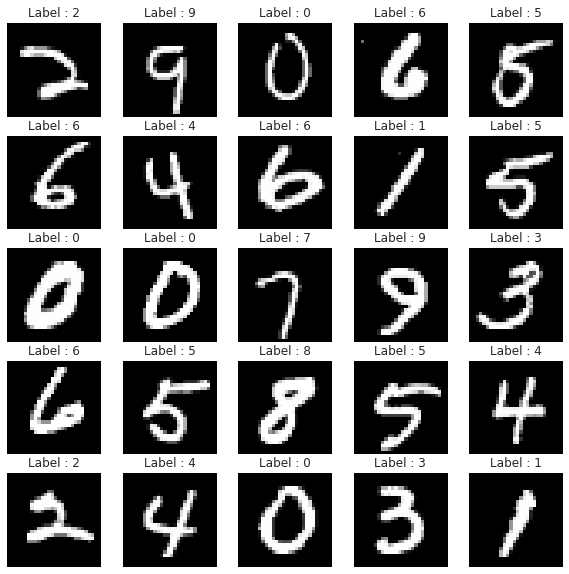

In [47]:
nrows = 5
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

rand_idx = np.random.randint(0, len(X_train), size=nrows*ncols)
images = X_train[rand_idx]
labels = y_train[rand_idx]

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[i], cmap='Greys_r')
    ax.set_title('Label : {0}'.format(labels[i]))
    ax.axis('off')
    ax.grid(False)

plt.show()

#### Convert labels to one-hot encoded arrays

In [48]:
y_train = label_binarize(y_train, classes=np.unique(y_train))
y_test = label_binarize(y_test, classes=np.unique(y_test))

In [49]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (60000, 28, 28)
y_train shape : (60000, 10)
X_test shape : (10000, 28, 28)
y_test shape : (10000, 10)


### 1./b. Training the model

In [51]:
def model_ex_1(imsize, stride, kernelsize,
               n_channels=1, num_of_filters=16, reg=5e-5,
               padding='same', activation='relu', n_class=10):
    """
    Using the modified version of Dezső Ribli's CNN, which I've used
    for my BSc thesis work.
    """
    # Tensorflow placeholder for inputs
    inputs = kl.Input(shape=(imsize, imsize, n_channels))

    #
    # Convolutional block 1.
    # 3x3CONVx16 -> ReLU -> 3x3CONVx16 -> ReLU -> MAXPOOLx2
    #
    x = kl.Conv2D(filters=num_of_filters,                   # 3x3CONVx32
                  kernel_size=(kernelsize, kernelsize),
                  padding=padding,
                  strides=(stride, stride),
                  kernel_regularizer=kr.l2(reg))(inp)
    x = kl.Activation(activation)(kl.BatchNormalization()(x))   # ReLU

    x = kl.Conv2D(filters=num_of_filters,                   # 3x3CONVx32
                  kernel_size=(kernelsize, kernelsize),
                  padding=padding,
                  strides=(stride, stride),
                  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation(activation)(kl.BatchNormalization()(x))   # ReLU

    x = kl.MaxPooling2D(strides=(2, 2))(x)                  # MAXPOOLx2


    #
    # Convolutional block 2.
    # 3x3CONVx32 -> ReLU -> 3x3CONVx32 -> ReLU -> MAXPOOLx2
    #
    x = kl.Conv2D(filters=2*num_of_filters,                 # 3x3CONVx64
                  kernel_size=(kernelsize, kernelsize),
                  padding=padding,
                  strides=(stride, stride),
                  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation(activation)(kl.BatchNormalization()(x))   # ReLU

    x = kl.Conv2D(filters=2*num_of_filters,                 # 3x3CONVx64
                  kernel_size=(kernelsize, kernelsize),
                  padding=padding,
                  strides=(stride, stride),
                  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation(activation)(kl.BatchNormalization()(x))   # ReLU
    
    x = kl.MaxPooling2D(strides=(2, 2))(x)                  # MAXPOOLx2

    # End of convolution
    x = kl.GlobalAveragePooling2D()(x)                      # AVGPOOL

    # Final flatten FC
    x = kl.Dense(units=n_class,
                 activation='softmax',
                 name = 'final_dense_n%d_ngpu%d' % (n_class, len(gpu.split(','))))(x)

    # Define model
    model = km.Model(inputs=inputs, outputs=x)

    # Multi GPU model
    if(len(gpu.split(',')) > 1):
        model = multi_gpu_model(model, gpus=len(gpu.split(',')))

    return model

In [ ]:
with tf.device('/gpu:' + used_gpu):
    best_model = kc.ModelCheckpoint('./models/best_model.hdf5', save_best_only=True, verbose=1)
    
    cnn_model = model_ex_1(imsize=28, stride=1, kernelsize=3,
                           n_channels=1, num_of_filters=16, reg=5e-5,
                           padding='same', activation='relu', n_class=10):

### 2. Download the Street View House Numbers (SVHN) Dataset

- source: http://ufldl.stanford.edu/housenumbers/
- use the cropped dataset!
- to get the dataset use eg. wget and keep the original splitting, so download train and test matrix files
- preprocess the downloaded data to be able to use it for training and testing, so shapes should be same (except image sizes) as it was in ex 1.
- how many classes do we have in the dataset? how many train and test examples do we have?
- what is the dimension of the images?
- show 5 images from the dataset
- make one-hot encoding for the labels

### 3. Train the CNN model seen in the 1st exercise for this dataset
* create a convolutional neural network
* the network should have the following layers:
        
        input (32, 32, 3)
        conv2D, 16 kernels, kernel size = 3, valid padding, relu actvation
        conv2D, 16 kernels, kernel size = 3, valid padding, relu actvation
        maxpooling kernel size = 2*2
        conv2D, 32 kernels, kernel size = 3, valid padding, relu actvation
        conv2D, 32 kernels, kernel size = 3, valid padding, relu actvation
        maxpooling kernel size = 2*2
        flatten
        dense, 10 neurons, softmax activation
        how many parameters do we have for each layer?

    * use Adam optimizer with default parameters
    * use categorical crossentropy as loss function
    * compile the model
    * print out a summary of the model
    * train the CNN on the training data for 15 epochs with batch size of 32
    * use the test data as validation data
- calculate the categorical cross-entropy loss and the accuracy! Hint: you should get at least ~80-90% accuracy

### 4. Evaluate performance

- plot the training and the validation loss on the same plot!
- plot the training and the validation accuracy on the same plot!
- do we overfit?
- show the confusion matrix of the predictions (predicted values vs actual labels)
- where does the model make mistakes?

### 5. Train an other CNN
- as we can see the previous architecture can be further improved
- come up with an architecture that can achieve more than 91% accuracy on the test set
- print out the summary for this model!
- plot the loss and accuracy curves for this model too!